# Preliminary data analysis

In [1]:
import numpy as np
import pandas as pd
import os
import pickle
from joblib import Parallel, delayed
import re
import matplotlib.pyplot as plt
import seaborn as sns

d = './raw_data/'

#### Import pre-processed data

In [3]:
with open('processed_data/clean_build.pkl', 'rb') as filename:  
    processed_data = pickle.load(filename)

/var/folders/_q/50__mrnj2zv6hb8crhk3q46m0000gn/T/ipykernel_14516/2922736232.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  processed_data = pickle.load(filename)


#### Look a variable types

In [4]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6822 entries, 0 to 6821
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     6822 non-null   object 
 1   budget                    6822 non-null   float64
 2   worldwide_boxoffice       6822 non-null   float64
 3   domestic_boxoffice        6822 non-null   float64
 4   clean_title               6822 non-null   object 
 5   imdb_id                   6812 non-null   object 
 6   release_date              6766 non-null   object 
 7   year                      6766 non-null   float64
 8   top_director              6822 non-null   object 
 9   top_cast                  6822 non-null   object 
 10  rating                    6822 non-null   float64
 11  runtime                   6822 non-null   float64
 12  original_language         6822 non-null   object 
 13  enrichment_source         6822 non-null   object 
 14  boxoffic

In [4]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49866 entries, 0 to 49865
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   final_title                 49866 non-null  object        
 1   final_budget                13828 non-null  float64       
 2   final_worldwide_boxoffice   12689 non-null  float64       
 3   final_domestic_boxoffice    15047 non-null  float64       
 4   final_genres                46160 non-null  object        
 5   final_runtime               44332 non-null  float64       
 6   final_overview              44670 non-null  object        
 7   final_certificate           22650 non-null  object        
 8   final_original_language     45277 non-null  object        
 9   final_rating                45288 non-null  float64       
 10  final_clean_title           49866 non-null  object        
 11  final_production_countries  45288 non-null  object    

In [5]:
processed_data.describe()

,final_budget,final_worldwide_boxoffice,final_domestic_boxoffice,final_runtime,final_rating,release_date,final_year
count,1.382800e+04,1.268900e+04,1.504700e+04,44332.000000,45288.000000,49717,49717.000000
mean,2.534096e+07,7.803956e+07,3.025413e+07,97.730556,5.624956,1994-01-02 18:16:53.592935936,1993.512078
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1874-12-09 00:00:00,1874.000000
25%,2.500000e+06,2.300000e+06,3.388375e+05,87.000000,5.000000,1981-08-14 00:00:00,1981.000000
50%,1.000000e+07,1.887501e+07,6.650206e+06,95.000000,6.000000,2003-01-01 00:00:00,2003.000000
75%,3.000000e+07,7.487087e+07,3.363182e+07,108.000000,6.800000,2011-09-03 00:00:00,2011.000000
max,5.332000e+08,2.923706e+09,9.366622e+08,1256.000000,10.000000,2068-12-11 00:00:00,2068.000000
std,3.970010e+07,1.677421e+08,6.102171e+07,34.455249,1.914652,NaN,23.878650


## EDA of numerical data

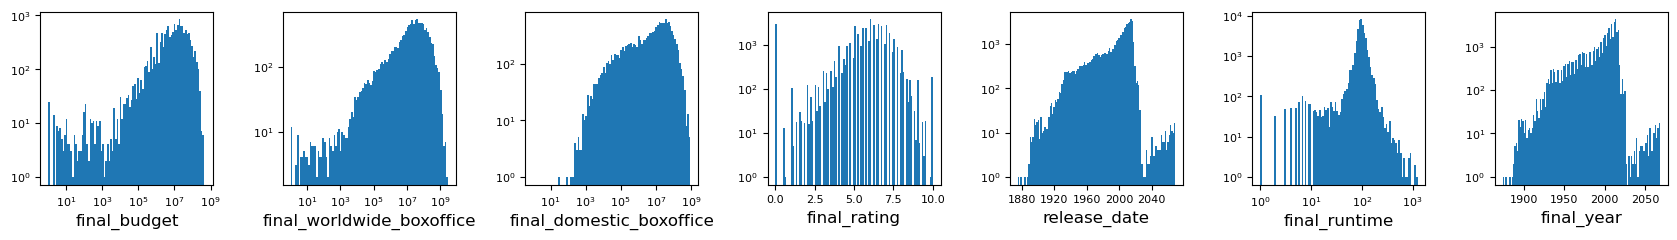

In [6]:
# Inspect distribution of observables
select_vars = ['final_budget', 'final_worldwide_boxoffice', 'final_domestic_boxoffice', 'final_rating', 'release_date', 'final_runtime', 'final_year']
fig, axs = plt.subplots(1, len(select_vars), figsize=(3*len(select_vars), 3), sharex=False, sharey=False)

for i, var in enumerate(select_vars):
    axs[i].hist(processed_data[var], bins=np.logspace(0,np.log10(np.amax(processed_data[var])), 100) if var not in ['final_rating', 'release_date', 'final_year'] else 'auto', log = True);
    if var not in ['final_rating', 'release_date', 'final_year']:
        axs[i].semilogx()
    axs[i].minorticks_off()
    axs[i].yaxis.set_tick_params(labelbottom=True)
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis='both', which='major', labelsize=8)
    axs[i].set_box_aspect(1)
    axs[i].set_xlabel(var, fontsize = 12)

fig.subplots_adjust(wspace=.4, hspace=.35)

Need to impose a lower cutoff for budget, release date and year. Also probably need an upper cut-off for release date since some values are unrealistic.

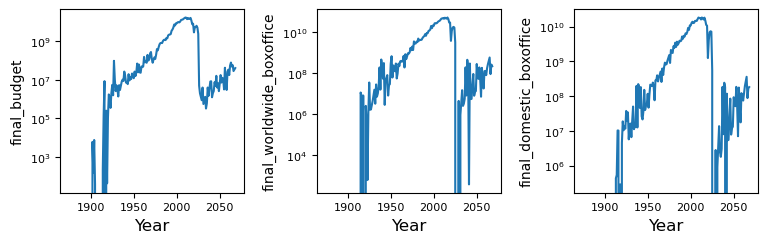

In [7]:
# Inspect distribution of observables
fig, axs = plt.subplots(1, 3, figsize=(3*3, 3), sharex=False, sharey=False)
input_data = processed_data[['final_year', 'final_budget', 'final_worldwide_boxoffice', 'final_domestic_boxoffice']].groupby(['final_year'], as_index = False).sum()

for i, var in enumerate(['final_budget', 'final_worldwide_boxoffice', 'final_domestic_boxoffice']):
    axs[i].plot(input_data['final_year'], input_data[var]);
    axs[i].semilogy()
    axs[i].minorticks_off()
    axs[i].yaxis.set_tick_params(labelbottom=True)
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis='both', which='major', labelsize=8)
    axs[i].set_box_aspect(1)
    axs[i].set_ylabel(var, fontsize = 10)
    axs[i].set_xlabel('Year', fontsize = 12)

fig.subplots_adjust(wspace=.4, hspace=.35)

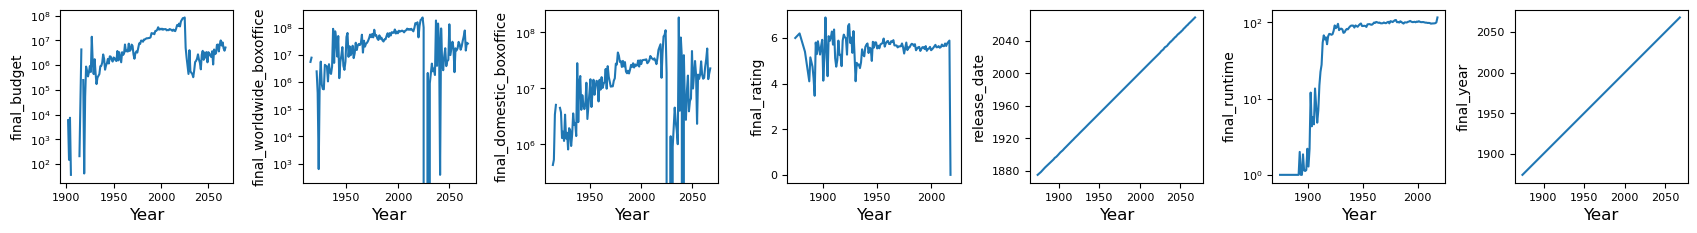

In [8]:
# Inspect distribution of observables
fig, axs = plt.subplots(1, len(select_vars), figsize=(3*len(select_vars), 3), sharex=False, sharey=False)
input_data = processed_data[select_vars].groupby(['final_year'], as_index = False).mean()

for i, var in enumerate(select_vars):
    axs[i].plot(input_data['final_year'], input_data[var]);
    if var not in ['final_rating', 'release_date', 'final_year']:
        axs[i].semilogy()
    axs[i].minorticks_off()
    axs[i].yaxis.set_tick_params(labelbottom=True)
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis='both', which='major', labelsize=8)
    axs[i].set_box_aspect(1)
    axs[i].set_ylabel(var, fontsize = 10)
    axs[i].set_xlabel('Year', fontsize = 12)

fig.subplots_adjust(wspace=.4, hspace=.35)

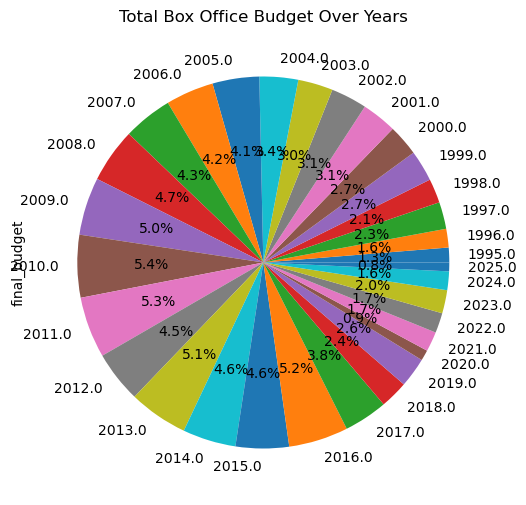

In [9]:
processed_data.loc[(processed_data.final_year >= 1995)*(processed_data.final_year <= 2025)].groupby("final_year")["final_budget"].sum().plot(kind="pie", figsize=(6,10), title="Total Box Office Budget Over Years", autopct='%1.1f%%')  
plt.show()

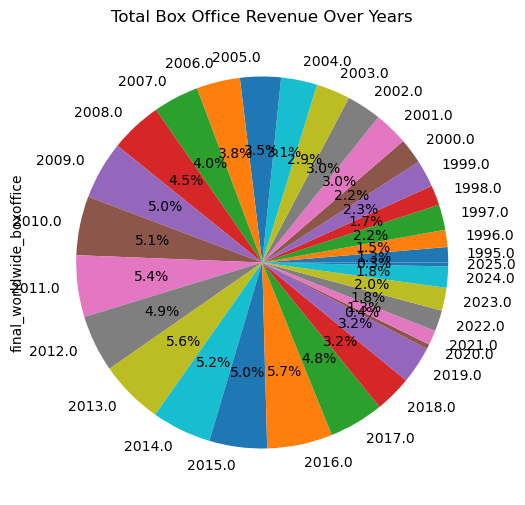

In [10]:
processed_data.loc[(processed_data.final_year >= 1995)*(processed_data.final_year <= 2025)].groupby("final_year")["final_worldwide_boxoffice"].sum().plot(kind="pie", figsize=(6,10), title="Total Box Office Revenue Over Years", autopct='%1.1f%%')  
plt.show()

#### Correlations in numeric data

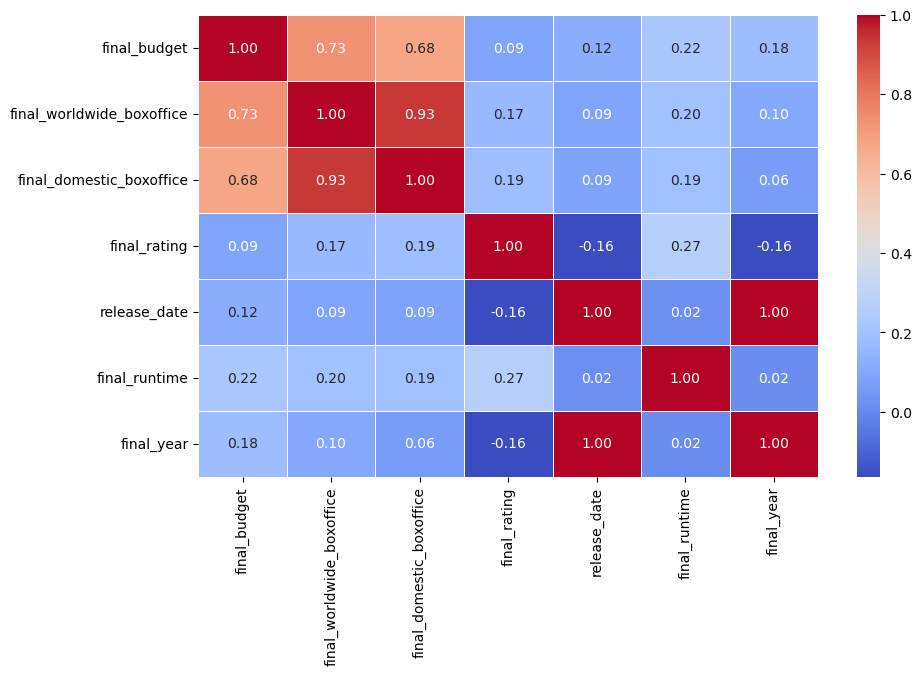

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(processed_data.loc[processed_data.final_budget >= 1000, select_vars].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, ax=ax)
plt.show()

## EDA of categorical data

In [12]:
from ast import literal_eval
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49866 entries, 0 to 49865
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   final_title                 49866 non-null  object        
 1   final_budget                13828 non-null  float64       
 2   final_worldwide_boxoffice   12689 non-null  float64       
 3   final_domestic_boxoffice    15047 non-null  float64       
 4   final_genres                46160 non-null  object        
 5   final_runtime               44332 non-null  float64       
 6   final_overview              44670 non-null  object        
 7   final_certificate           22650 non-null  object        
 8   final_original_language     45277 non-null  object        
 9   final_rating                45288 non-null  float64       
 10  final_clean_title           49866 non-null  object        
 11  final_production_countries  45288 non-null  object    

In [13]:
features = ['cast', 'crew', 'final_genres', 'final_production_countries', 'production_companies']
for feature in features:
    processed_data.loc[:, feature] = processed_data[feature].fillna("")
    processed_data.loc[processed_data['_merge'] != 'right_only', feature] = processed_data.loc[processed_data['_merge'] != 'right_only', feature].apply(literal_eval)

In [14]:
# Functions to extract the directors name from crew, and get top 3 crew members from crew
def get_director(x):
    for i in x:
        if i['job'] == "Director":
            return i['name']

    return np.nan

def get_list(x):
    if isinstance(x, list):
        entries = [i['name'] for i in x]
        # keep only top 3 entries
        if len(entries) > 3:
            entries = entries[:3]
        return entries

    return np.nan

def get_entry(x, entry = 'name', rank = 0):
    if isinstance(x, list):
        entries = [i[entry] for i in x]
        # keep only top 3 entries
        if len(entries) > rank:
            out = entries[rank]
        else:
            out = np.nan
        return out

    return np.nan

In [25]:
processed_data['star'][8]

'Geoffrey Rush, \nAnthony LaPaglia, \nSamuel Johnson, \nBarry Otto'

In [22]:
processed_data['director_id']

0                     NaN
1                     NaN
2                     NaN
3        /name/nm0836964/
4        /name/nm5056902/
               ...       
49861                 NaN
49862    /name/nm0840671/
49863    /name/nm1066739/
49864    /name/nm0001429/
49865                 NaN
Name: director_id, Length: 49866, dtype: object

In [15]:
processed_data.loc[:, 'final_director'] = processed_data['crew'].apply(get_director).fillna(processed_data['director'])

for feature in ['cast', 'final_genres']:
    processed_data.loc[:, 'top_'+feature] = processed_data[feature].apply(get_list)

for i in np.arange(0,3):
    processed_data.loc[:, 'actor_name'+str(i)] = processed_data['cast'].apply(get_entry, args = (['name', i]))
    processed_data.loc[:, 'actor_id_'+str(i)] = processed_data['cast'].apply(get_entry, args = (['id', i]))
    processed_data.loc[:, 'genre_name'+str(i)] = processed_data['final_genres'].apply(get_entry, args = (['name', i]))
    processed_data.loc[:, 'production_country_'+str(i)] = processed_data['final_production_countries'].apply(get_entry, args = (['name', i]))
    processed_data.loc[:, 'production_company_'+str(i)] = processed_data['production_companies'].apply(get_entry, args = (['name', i]))

In [18]:
# !pip install ydata_profiling

# from ydata_profiling import ProfileReport

ImportError: Numba needs NumPy 2.1 or less. Got NumPy 2.2.

In [ ]:
profile = ProfileReport(processed_data, title="Movie Dataset Profiling Report")
profile.to_file("movie_data_report.html")